# 우주선 타이타닉

우주선 타이타닉이 충돌하는 동안 어떤 승객이 변칙적으로 운송되었는지 예측

## 파일 및 데이터 필드 설명

https://www.kaggle.com/competitions/spaceship-titanic

- **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.  

  - `PassengerId` : A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
  - `HomePlanet` : The planet the passenger departed from, typically their planet of permanent residence.
  - `CryoSleep` : Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  - `Cabin` : The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  - `Destination` : The planet the passenger will be debarking to.
  - `Age` : The age of the passenger.
  - `VIP` : Whether the passenger has paid for special VIP service during the voyage.
  - `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` : Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  - `Name` : The first and last names of the passenger.
  - `Transported` : Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.  
</br>
- **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
- **sample_submission.csv** - A submission file in the preprocessingect format.  
  - `PassengerId` : Id for each passenger in the test set.  
  - `Transported` : The target. For each passenger, predict either True or False.

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_df = pd.read_csv('spaceship-titanic/train.csv')
test_df = pd.read_csv('spaceship-titanic/test.csv')
origin_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

origin_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [3]:
origin_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

## Feature Engineering

1. 결측치 확인
2. 데이터 전처리
3. 결측치 제거 후 상관관계분석 - 결측치 처리 전략 세우기
4. 결측치 처리
5. 최종 데이터모판 생성

### 1. 결측치 확인

In [4]:
origin_df.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

PassengerId & HomePlanet & Destination & Cabin
- 같은 group이면 같은 HomePlanet ?
- 같은 group이면 같은 Destination ?
- 같은 group이면 같은 Cabin ?

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- 지불 금액이 0원일 때 Nan인가 ?
  - 0, NaN 둘다 존재

Age & VIP & CryoSleep
- 나이가 많으면 VIP일 확률이 높나 ?
- 나이에 따라 CryoSleep 여부가 영향을 받나 ?

### 결측치 처리전략을 위한 상관관계분석 필요

### 2. 데이터 전처리

In [5]:
origin_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


#### one-hot encoding

In [6]:
origin_df.groupby(['HomePlanet']).size()

HomePlanet
Earth     6865
Europa    3133
Mars      2684
dtype: int64

In [7]:
origin_df.groupby(['Cabin']).size()

Cabin
A/0/P     2
A/0/S     2
A/1/P     1
A/1/S     3
A/10/P    1
         ..
T/2/P     1
T/2/S     1
T/3/P     1
T/3/S     3
T/4/P     1
Length: 9825, dtype: int64

In [8]:
origin_df.groupby(['Destination']).size()

Destination
55 Cancri e      2641
PSO J318.5-22    1184
TRAPPIST-1e      8871
dtype: int64

`Cabin` form : `deck/num/side`  
`split`을 이용하여 `deck`, `side` column 따로 생성

In [9]:
def get_cabin_deck(Cabin : str):
  if pd.isna(Cabin):
    deck = None
  else :
    deck = Cabin.split('/')[0]
  return deck

def get_cabin_side(Cabin : str):
  if pd.isna(Cabin):
    side = None
  else :
    side = Cabin.split('/')[2]
  return side

#### map

In [10]:
origin_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


True : 1, False : 0
- `CryoSleep`
- `VIP`
- `Transported`

#### feature 삭제
- id 특성의 feature
- 전처리 완료된 문자열 feature

In [11]:
origin_df['PassengerId']

0        0001_01
1        0002_01
2        0003_01
3        0003_02
4        0004_01
          ...   
12965    9266_02
12966    9269_01
12967    9271_01
12968    9273_01
12969    9277_01
Name: PassengerId, Length: 12970, dtype: object

In [12]:
origin_df['Name']

0          Maham Ofracculy
1             Juanna Vines
2            Altark Susent
3             Solam Susent
4        Willy Santantines
               ...        
12965          Jeron Peter
12966        Matty Scheron
12967          Jayrin Pore
12968       Kitakan Conale
12969     Lilace Leonzaley
Name: Name, Length: 12970, dtype: object

In [13]:
def get_passenger_group_num(PassengerId : str):
  group_num = PassengerId.split('_')[0]
  return group_num

len(origin_df['PassengerId'].apply(get_passenger_group_num).unique())

9280

one-hot encoding 하기엔 uniqe한 value의 수가 너무 많음  
상관관계분석에서는 활용하지 않음  
전체 12970명, 그룹 9280개 (개인이 하나의 그룹을 이루는 경우도 존재)

#### code

In [14]:
preprocessing_df = origin_df.copy()
binary_dict = {True : 1, False : 0}
preprocessing_df['CryoSleep'] = preprocessing_df['CryoSleep'].map(binary_dict)
preprocessing_df['VIP'] = preprocessing_df['VIP'].map(binary_dict)
preprocessing_df['Transported'] = preprocessing_df['Transported'].map(binary_dict)

preprocessing_df['PassengerGroup'] = preprocessing_df['PassengerId'].apply(get_passenger_group_num)
preprocessing_df['CabinDeck'] = preprocessing_df['Cabin'].apply(get_cabin_deck)
preprocessing_df['CabinSide'] = preprocessing_df['Cabin'].apply(get_cabin_side)

preprocessing_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
preprocessing_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,None,None
12967,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


### 3. 결측치 제거 후 상관관계분석

one-hot encoding 하기 전 dropna로 상관관계분석이 가능한 데이터프레임 생성

In [15]:
dropna_df = preprocessing_df.copy()
dropna_df.dropna(inplace=True)
dropna_df = dropna_df.drop('PassengerGroup', axis=1)
dropna_df = pd.get_dummies(dropna_df, columns=['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'])
dropna_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,1,...,0,0,0,0,0,1,0,0,0,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0,...,1,0,0,0,0,0,0,0,1,0
8689,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
8690,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1.0,1,...,0,0,0,0,0,0,1,0,0,1
8691,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0.0,0,...,0,0,0,0,1,0,0,0,0,1


#### data scaling

In [16]:
minmax_scaler = MinMaxScaler()
dropna_scaled_data = minmax_scaler.fit_transform(dropna_df)
dropna_scaled_data

array([[0.        , 0.49367089, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.30379747, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.73417722, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.32911392, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.40506329, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.55696203, 0.        , ..., 0.        , 0.        ,
        1.        ]])

#### correlation

In [17]:
corr_data = np.corrcoef(dropna_scaled_data.T)
corr_data.shape

(25, 25)

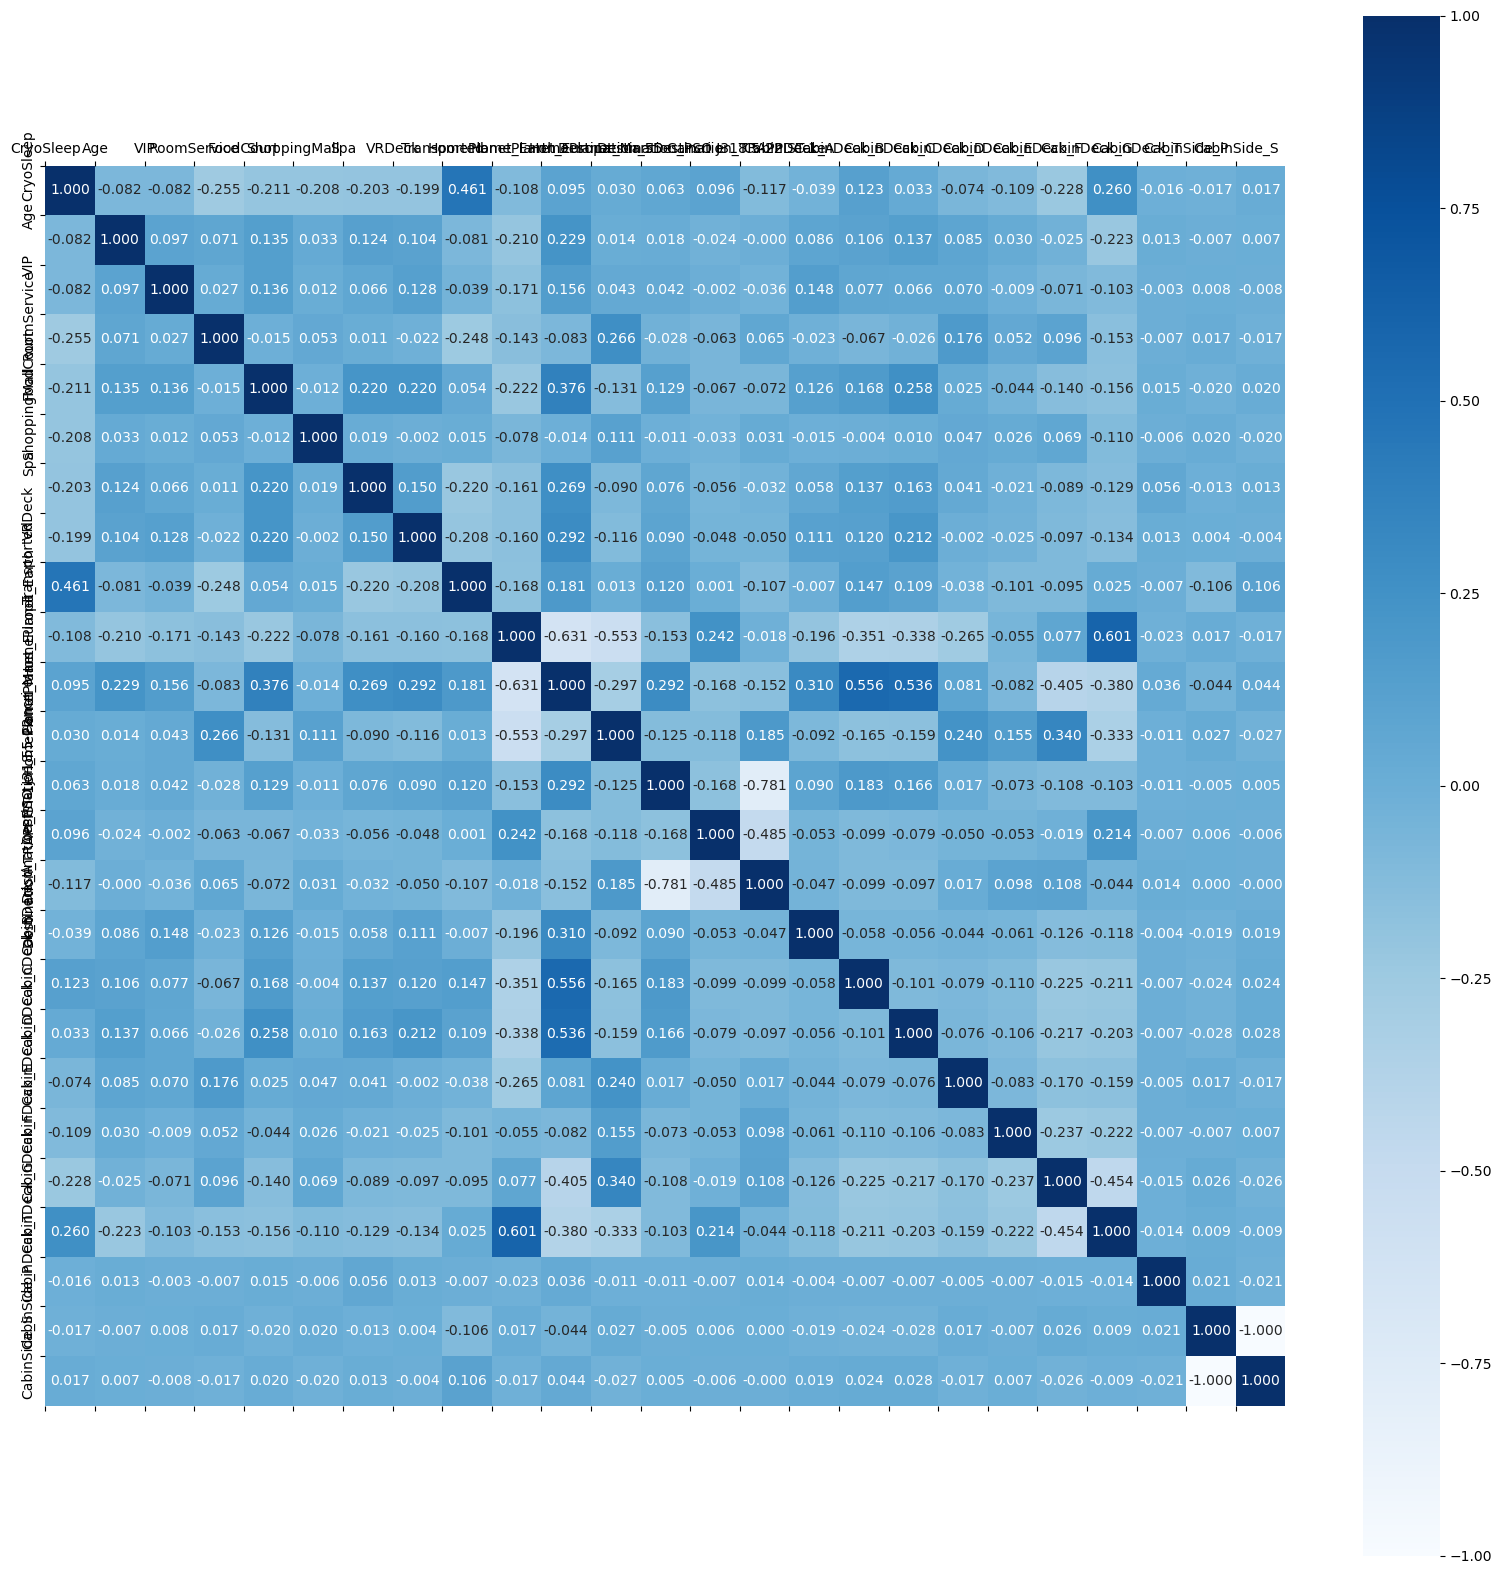

In [18]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

sns.heatmap(corr_data, fmt='.3f', annot=True, cmap='Blues')
cax = ax.matshow(corr_data, vmin=-1, vmax=1, interpolation='nearest', cmap='Blues')
ticks = np.arange(0, 25, 1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(dropna_df.columns)
ax.set_yticklabels(dropna_df.columns)

plt.show()


상관계수의 절댓값이 0.4 이상인 feature 찾기

In [19]:
corr_df = pd.DataFrame(corr_data, columns=dropna_df.columns, index=dropna_df.columns)
corr_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
CryoSleep,1.000000,-0.081778,-0.081929,-0.255168,-0.210802,-0.208454,-0.203047,-0.199151,0.461480,-0.107724,...,-0.038905,0.123092,0.032946,-0.073933,-0.109060,-0.228379,0.260190,-0.015521,-0.017257,0.017257
Age,-0.081778,1.000000,0.096911,0.070945,0.135226,0.032701,0.123769,0.103562,-0.080535,-0.210396,...,0.085647,0.105785,0.137342,0.084880,0.029894,-0.025249,-0.223042,0.012714,-0.006542,0.006542
VIP,-0.081929,0.096911,1.000000,0.027346,0.136350,0.012405,0.065783,0.127957,-0.039334,-0.170967,...,0.147699,0.076983,0.065894,0.069882,-0.009379,-0.070791,-0.102825,-0.003321,0.007772,-0.007772
RoomService,-0.255168,0.070945,0.027346,1.000000,-0.014529,0.053498,0.010538,-0.021664,-0.247801,-0.143322,...,-0.022775,-0.066712,-0.025922,0.175956,0.051562,0.095680,-0.153198,-0.007295,0.016650,-0.016650
FoodCourt,-0.210802,0.135226,0.136350,-0.014529,1.000000,-0.011812,0.220404,0.219689,0.053850,-0.222298,...,0.126059,0.167986,0.258375,0.025100,-0.044417,-0.139925,-0.156428,0.014877,-0.019672,0.019672
ShoppingMall,-0.208454,0.032701,0.012405,0.053498,-0.011812,1.000000,0.019142,-0.002006,0.014998,-0.077926,...,-0.014809,-0.003699,0.010224,0.047042,0.026315,0.069172,-0.110155,-0.005938,0.019647,-0.019647
Spa,-0.203047,0.123769,0.065783,0.010538,0.220404,0.019142,1.000000,0.150377,-0.220134,-0.161024,...,0.057978,0.136816,0.162931,0.041327,-0.021258,-0.088800,-0.129101,0.055847,-0.013065,0.013065
VRDeck,-0.199151,0.103562,0.127957,-0.021664,0.219689,-0.002006,0.150377,1.000000,-0.207761,-0.159883,...,0.110764,0.119837,0.211617,-0.002136,-0.024926,-0.096957,-0.133935,0.012957,0.003752,-0.003752
Transported,0.461480,-0.080535,-0.039334,-0.247801,0.053850,0.014998,-0.220134,-0.207761,1.000000,-0.168071,...,-0.006939,0.147090,0.109091,-0.037924,-0.100925,-0.095346,0.025090,-0.007140,-0.106385,0.106385
HomePlanet_Earth,-0.107724,-0.210396,-0.170967,-0.143322,-0.222298,-0.077926,-0.161024,-0.159883,-0.168071,1.000000,...,-0.195568,-0.350921,-0.338072,-0.264980,-0.054887,0.076904,0.601433,-0.022846,0.016758,-0.016758


양의 상관관계 찾기

In [20]:
corr_df.columns[corr_df[corr_df > 0.4].count() > 1]

Index(['CryoSleep', 'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_G'],
      dtype='object')

In [21]:
corr_df['CabinDeck_G'].sort_values(ascending=False).head(5)

CabinDeck_G                  1.000000
HomePlanet_Earth             0.601433
CryoSleep                    0.260190
Destination_PSO J318.5-22    0.214108
Transported                  0.025090
Name: CabinDeck_G, dtype: float64

음의 상관관계 찾기

In [22]:
corr_df.columns[corr_df[corr_df < -0.4].count() > 1]

Index(['HomePlanet_Earth', 'HomePlanet_Europa', 'Destination_TRAPPIST-1e',
       'CabinDeck_F'],
      dtype='object')

In [23]:
corr_df['CabinDeck_F'].sort_values().head(5)

CabinDeck_G         -0.454107
HomePlanet_Europa   -0.405096
CabinDeck_E         -0.236525
CryoSleep           -0.228379
CabinDeck_B         -0.225245
Name: CabinDeck_F, dtype: float64

In [24]:
corr_df['Transported'].sort_values(ascending=False).head()

Transported                1.000000
CryoSleep                  0.461480
HomePlanet_Europa          0.180725
CabinDeck_B                0.147090
Destination_55 Cancri e    0.119810
Name: Transported, dtype: float64

### 상관관계분석 결과

양의 상관관계
- HomePlanet_Earth, CabinDeck_G : 0.601433
- HomePlanet_Europa, CabinDeck_B : 0.556028
- HomePlanet_Europa, CabinDeck_C : 0.535669

음의 상관관계
- HomePlanet_Europa, CabinDeck_F : -0.405096

### 4. 결측치 처리

In [25]:
processed_df = preprocessing_df.copy()
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,None,None
12967,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


#### 1. HomePlanet

- `PassengerGroup`은 가족을 의미 (항상 그런 것은 아님)
- 가족구성원끼리 `HomePlanet`이 동일할 것으로 추측

In [26]:
temp_group_list = processed_df['PassengerGroup'].value_counts()[20:24].index
processed_df[processed_df['PassengerGroup'].isin(temp_group_list)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
196,Earth,1.0,TRAPPIST-1e,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0220,G,P
197,Earth,0.0,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0220,G,P
198,Earth,1.0,TRAPPIST-1e,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0220,G,P
199,Earth,0.0,TRAPPIST-1e,25.0,0.0,122.0,84.0,NaN,0.0,0.0,0.0,0220,E,P
200,Earth,0.0,TRAPPIST-1e,16.0,0.0,0.0,3.0,0.0,0.0,1099.0,0.0,0220,F,P
201,Earth,0.0,55 Cancri e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0220,G,P
202,Earth,1.0,TRAPPIST-1e,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0220,G,P
203,Mars,0.0,55 Cancri e,21.0,0.0,2237.0,0.0,119.0,0.0,0.0,0.0,0221,E,S
204,Mars,0.0,TRAPPIST-1e,23.0,0.0,1215.0,80.0,1.0,2.0,0.0,0.0,0221,E,S
205,Mars,0.0,TRAPPIST-1e,33.0,0.0,1933.0,12.0,188.0,1.0,0.0,0.0,0221,E,S


- `PassengerGroup`를 기준으로 분류하고 그룹 내 `HomePlanet`의 최빈값으로 결측치 채우기
- 단, 가족구성원이 없고 혼자 `None`인 경우 전체 최빈값으로 결측치 채우기

In [27]:
all_HomePlanet_mode = processed_df['HomePlanet'].mode()[0]
filled_HomePlanet_list = []

for name, value in processed_df.groupby('PassengerGroup'):
  if value['HomePlanet'].value_counts().tolist():
    group_HomePlanet_mode = value['HomePlanet'].value_counts().index[0]
    filled_HomePlanet_list.append(value['HomePlanet'].fillna(group_HomePlanet_mode))
  else :
    filled_HomePlanet_list.append(value['HomePlanet'].fillna(all_HomePlanet_mode))

filled_HomePlanet_col = pd.concat(filled_HomePlanet_list).sort_index()
filled_HomePlanet_col

0        Europa
1         Earth
2        Europa
3        Europa
4         Earth
          ...  
12965     Earth
12966     Earth
12967      Mars
12968    Europa
12969     Earth
Name: HomePlanet, Length: 12970, dtype: object

In [28]:
processed_df['HomePlanet'] = filled_HomePlanet_col
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,None,None
12967,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


#### 2. CabinDeck, CabinSide

CabinDeck
- `HomePlanet`과 상관관계를 보임

CabinSide
- `CabinSide`와의 상관관계계수 절댓값이 0.1이상인 feature는 아무것도 없음
- 그룹별 데이터프레임을 보면 `HomePlanet`과 마찬가지로 `CabinSide`가 모두 동일함

In [29]:
temp_group_list = processed_df['PassengerGroup'].value_counts().head(5).index
processed_df[processed_df['PassengerGroup'].isin(temp_group_list)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
910,Earth,0.0,TRAPPIST-1e,45.0,0.0,0.0,1.0,13.0,0.0,873.0,0.0,0984,G,S
911,Earth,0.0,TRAPPIST-1e,24.0,0.0,0.0,0.0,718.0,0.0,0.0,0.0,0984,F,S
912,Earth,0.0,TRAPPIST-1e,23.0,0.0,0.0,0.0,490.0,0.0,319.0,0.0,0984,G,S
913,Earth,1.0,TRAPPIST-1e,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0984,G,S
914,Earth,0.0,55 Cancri e,20.0,0.0,0.0,11.0,0.0,136.0,1088.0,0.0,0984,F,S
915,Earth,1.0,TRAPPIST-1e,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0984,G,S
916,Earth,1.0,PSO J318.5-22,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0984,G,S
917,Earth,1.0,TRAPPIST-1e,71.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0984,G,S
3988,Earth,0.0,TRAPPIST-1e,27.0,0.0,6.0,0.0,0.0,768.0,1141.0,0.0,4256,F,P
3989,Earth,1.0,TRAPPIST-1e,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4256,G,P


갯수가 더 적은 값으로 결측치 채우기  
- `CabinSide`는 P 또는 S : 배의 좌우 측면을 의미  
- P와 S의 갯수가 거의 동일할 것  

In [30]:
preprocessing_df.groupby('CabinSide').size()

CabinSide
P    6290
S    6381
dtype: int64

In [31]:
less_CabinSide = processed_df['CabinSide'].value_counts(ascending=True).index[0]
less_CabinSide

'P'

In [32]:
filled_CabinSide_list = []

for name, value in processed_df.groupby('PassengerGroup'):
  if value['CabinSide'].value_counts().tolist():
    group_CabinSide_mode = value['CabinSide'].value_counts().index[0]
    filled_CabinSide_list.append(value['CabinSide'].fillna(group_CabinSide_mode))
  else :
    filled_CabinSide_list.append(value['CabinSide'].fillna(less_CabinSide))

filled_CabinSide_col = pd.concat(filled_CabinSide_list).sort_index()
filled_CabinSide_col

0        P
1        S
2        S
3        S
4        S
        ..
12965    S
12966    P
12967    P
12968    P
12969    S
Name: CabinSide, Length: 12970, dtype: object

In [33]:
processed_df['CabinSide'] = filled_CabinSide_col
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,None,P
12967,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


In [34]:
processed_df.groupby('CabinSide').size()

CabinSide
P    6516
S    6454
dtype: int64

`HomePlanet`과 `CabinDeck`의 상관관계를 이용한 맵핑

In [35]:
preprocessing_df[preprocessing_df['CabinDeck'].isna()].groupby('HomePlanet').size()

HomePlanet
Earth     156
Europa     79
Mars       57
dtype: int64

양의 상관관계
- HomePlanet_Earth, CabinDeck_G : 0.601433
- HomePlanet_Europa, CabinDeck_B : 0.556028
- HomePlanet_Europa, CabinDeck_C : 0.535669

음의 상관관계
- HomePlanet_Europa, CabinDeck_F : -0.405096

In [36]:
corr_df['HomePlanet_Mars'].sort_values(ascending=False).head()

HomePlanet_Mars            1.000000
CabinDeck_F                0.340331
RoomService                0.265964
CabinDeck_D                0.239681
Destination_TRAPPIST-1e    0.185144
Name: HomePlanet_Mars, dtype: float64

In [37]:
filled_CabinDeck_col = []

for name, value in processed_df.groupby('HomePlanet'):
  if name == 'Earth':
    filled_CabinDeck_col.append(value['CabinDeck'].fillna('G'))
  elif name == 'Europa':
    filled_CabinDeck_col.append(value['CabinDeck'].fillna('B'))
  elif name == 'Mars':
    filled_CabinDeck_col.append(value['CabinDeck'].fillna('F'))

filled_CabinDeck_col = pd.concat(filled_CabinDeck_col).sort_index()
filled_CabinDeck_col
  

0        B
1        F
2        A
3        A
4        F
        ..
12965    G
12966    G
12967    D
12968    D
12969    G
Name: CabinDeck, Length: 12970, dtype: object

In [38]:
processed_df['CabinDeck'] = filled_CabinDeck_col
processed_df.isna().sum()

HomePlanet           0
CryoSleep          310
Destination        274
Age                270
VIP                296
RoomService        263
FoodCourt          289
ShoppingMall       306
Spa                284
VRDeck             268
Transported       4277
PassengerGroup       0
CabinDeck            0
CabinSide            0
dtype: int64

#### 3. CryoSleep

In [39]:
processed_df.groupby('CryoSleep').size()

CryoSleep
0.0    8079
1.0    4581
dtype: int64

0으로 모두 채우기엔 1의 값이 적지 않고 `transported`와 `CryoSleep`이 양의 상관관계를 보임

In [40]:
corr_df['CryoSleep'].sort_values()

RoomService                 -0.255168
CabinDeck_F                 -0.228379
FoodCourt                   -0.210802
ShoppingMall                -0.208454
Spa                         -0.203047
VRDeck                      -0.199151
Destination_TRAPPIST-1e     -0.116983
CabinDeck_E                 -0.109060
HomePlanet_Earth            -0.107724
VIP                         -0.081929
Age                         -0.081778
CabinDeck_D                 -0.073933
CabinDeck_A                 -0.038905
CabinSide_P                 -0.017257
CabinDeck_T                 -0.015521
CabinSide_S                  0.017257
HomePlanet_Mars              0.030167
CabinDeck_C                  0.032946
Destination_55 Cancri e      0.063203
HomePlanet_Europa            0.095403
Destination_PSO J318.5-22    0.096050
CabinDeck_B                  0.123092
CabinDeck_G                  0.260190
Transported                  0.461480
CryoSleep                    1.000000
Name: CryoSleep, dtype: float64

In [41]:
processed_df.groupby(['CabinDeck', 'CryoSleep']).size()

CabinDeck  CryoSleep
A          0.0           242
           1.0           102
B          0.0           546
           1.0           646
C          0.0           611
           1.0           462
D          0.0           538
           1.0           169
E          0.0          1040
           1.0           252
F          0.0          3320
           1.0           874
G          0.0          1772
           1.0          2076
T          0.0            10
dtype: int64

In [42]:
processed_df['CabinDeck'].unique()

array(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'], dtype=object)

In [43]:
filled_CryoSleep_col = []

for name, value in processed_df.groupby('CabinDeck'):
  group_CabinDeck_mode = value['CryoSleep'].value_counts().index[0]
  filled_CryoSleep_col.append(value['CryoSleep'].fillna(group_CabinDeck_mode))

filled_CryoSleep_col = pd.concat(filled_CryoSleep_col).sort_index()
filled_CryoSleep_col

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12965    1.0
12966    0.0
12967    1.0
12968    0.0
12969    1.0
Name: CryoSleep, Length: 12970, dtype: float64

In [44]:
processed_df['CryoSleep'] = filled_CryoSleep_col
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,G,P
12967,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


In [45]:
processed_df.isna().sum()

HomePlanet           0
CryoSleep            0
Destination        274
Age                270
VIP                296
RoomService        263
FoodCourt          289
ShoppingMall       306
Spa                284
VRDeck             268
Transported       4277
PassengerGroup       0
CabinDeck            0
CabinSide            0
dtype: int64

#### 4. Destination

In [46]:
processed_df.groupby('Destination').size()

Destination
55 Cancri e      2641
PSO J318.5-22    1184
TRAPPIST-1e      8871
dtype: int64

`TRAPPIST-1e`로 모든 결측치 채우기 ?

In [47]:
corr_df['Destination_TRAPPIST-1e'].sort_values().head(7)

Destination_55 Cancri e     -0.780586
Destination_PSO J318.5-22   -0.484783
HomePlanet_Europa           -0.152034
CryoSleep                   -0.116983
Transported                 -0.107076
CabinDeck_B                 -0.099180
CabinDeck_C                 -0.096530
Name: Destination_TRAPPIST-1e, dtype: float64

`HomePlanet_Europa`와 음의 상관관계  
`HomePlanet_Europa`와 양의 상관관계를 갖는 `Destination`이 존재하는지 확인

In [48]:
corr_df['Destination_PSO J318.5-22'].sort_values(ascending=False).head(7)

Destination_PSO J318.5-22    1.000000
HomePlanet_Earth             0.242318
CabinDeck_G                  0.214108
CryoSleep                    0.096050
CabinSide_P                  0.006131
Transported                  0.001215
VIP                         -0.001699
Name: Destination_PSO J318.5-22, dtype: float64

In [49]:
corr_df['Destination_55 Cancri e'].sort_values(ascending=False).head(7)

Destination_55 Cancri e    1.000000
HomePlanet_Europa          0.291664
CabinDeck_B                0.182831
CabinDeck_C                0.165558
FoodCourt                  0.129171
Transported                0.119810
VRDeck                     0.090143
Name: Destination_55 Cancri e, dtype: float64

결론 : `HomePlanet_Europa`인 행은 `55 Cancri e`로, 그 외는 `TRAPPIST-1e`로 채우기

In [50]:
all_Destination_mode = processed_df.groupby('Destination').size().sort_values(ascending=False).index[0]
Europa_Destination = '55 Cancri e'
all_Destination_mode

'TRAPPIST-1e'

In [51]:
filled_Destination_col = []

for name, value in processed_df.groupby('HomePlanet'):
  if name == 'Europa':
    filled_Destination_col.append(value['Destination'].fillna(Europa_Destination))
  else:
    filled_Destination_col.append(value['Destination'].fillna(all_Destination_mode))

filled_Destination_col = pd.concat(filled_Destination_col).sort_index()
filled_Destination_col

0          TRAPPIST-1e
1          TRAPPIST-1e
2          TRAPPIST-1e
3          TRAPPIST-1e
4          TRAPPIST-1e
             ...      
12965      TRAPPIST-1e
12966      TRAPPIST-1e
12967      55 Cancri e
12968      55 Cancri e
12969    PSO J318.5-22
Name: Destination, Length: 12970, dtype: object

In [52]:
processed_df['Destination'] = filled_Destination_col
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,G,P
12967,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,55 Cancri e,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


#### 5. Age

<AxesSubplot:>

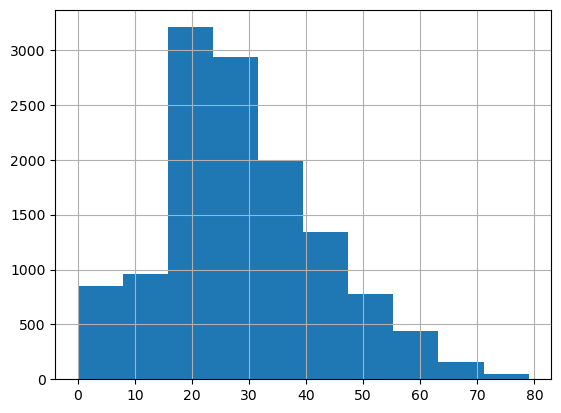

In [53]:
processed_df['Age'].hist()

In [54]:
corr_df['Age'].sort_values()

CabinDeck_G                 -0.223042
HomePlanet_Earth            -0.210396
CryoSleep                   -0.081778
Transported                 -0.080535
CabinDeck_F                 -0.025249
Destination_PSO J318.5-22   -0.024279
CabinSide_P                 -0.006542
Destination_TRAPPIST-1e     -0.000190
CabinSide_S                  0.006542
CabinDeck_T                  0.012714
HomePlanet_Mars              0.013532
Destination_55 Cancri e      0.017565
CabinDeck_E                  0.029894
ShoppingMall                 0.032701
RoomService                  0.070945
CabinDeck_D                  0.084880
CabinDeck_A                  0.085647
VIP                          0.096911
VRDeck                       0.103562
CabinDeck_B                  0.105785
Spa                          0.123769
FoodCourt                    0.135226
CabinDeck_C                  0.137342
HomePlanet_Europa            0.228600
Age                          1.000000
Name: Age, dtype: float64

In [55]:
filled_Age_col = []

for name, value in processed_df.groupby('HomePlanet'):
  group_Age_mean = round(value['Age'].mean())
  filled_Age_col.append(value['Age'].fillna(group_Age_mean))

filled_Age_col = pd.concat(filled_Age_col).sort_index()
filled_Age_col

0        39.0
1        24.0
2        58.0
3        33.0
4        16.0
         ... 
12965    34.0
12966    42.0
12967    29.0
12968    34.0
12969    43.0
Name: Age, Length: 12970, dtype: float64

In [56]:
processed_df['Age'] = filled_Age_col
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,G,P
12967,Mars,1.0,55 Cancri e,29.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,55 Cancri e,34.0,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


In [57]:
processed_df.isna().sum()

HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                296
RoomService        263
FoodCourt          289
ShoppingMall       306
Spa                284
VRDeck             268
Transported       4277
PassengerGroup       0
CabinDeck            0
CabinSide            0
dtype: int64

#### 6. VIP

In [58]:
processed_df[processed_df['VIP'] == 1]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
108,Europa,0.0,55 Cancri e,48.0,1.0,0.0,2537.0,87.0,17.0,13.0,1.0,0112,B,S
120,Mars,0.0,TRAPPIST-1e,61.0,1.0,2353.0,334.0,9.0,316.0,2.0,0.0,0128,D,S
214,Mars,0.0,TRAPPIST-1e,32.0,1.0,181.0,0.0,5.0,1634.0,0.0,0.0,0224,F,S
291,Earth,0.0,TRAPPIST-1e,59.0,1.0,1018.0,0.0,209.0,0.0,0.0,0.0,0321,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12785,Mars,0.0,TRAPPIST-1e,43.0,1.0,12.0,0.0,1039.0,6.0,0.0,NaN,8911,D,P
12808,Mars,0.0,TRAPPIST-1e,55.0,1.0,1176.0,0.0,6.0,967.0,2.0,NaN,8936,E,S
12826,Mars,0.0,PSO J318.5-22,39.0,1.0,369.0,0.0,1636.0,0.0,0.0,NaN,8979,F,S
12845,Europa,0.0,55 Cancri e,30.0,1.0,0.0,1517.0,0.0,14252.0,4617.0,NaN,9016,B,S


In [59]:
corr_df['VIP'].sort_values()

HomePlanet_Earth            -0.170967
CabinDeck_G                 -0.102825
CryoSleep                   -0.081929
CabinDeck_F                 -0.070791
Transported                 -0.039334
Destination_TRAPPIST-1e     -0.036482
CabinDeck_E                 -0.009379
CabinSide_S                 -0.007772
CabinDeck_T                 -0.003321
Destination_PSO J318.5-22   -0.001699
CabinSide_P                  0.007772
ShoppingMall                 0.012405
RoomService                  0.027346
Destination_55 Cancri e      0.042331
HomePlanet_Mars              0.043043
Spa                          0.065783
CabinDeck_C                  0.065894
CabinDeck_D                  0.069882
CabinDeck_B                  0.076983
Age                          0.096911
VRDeck                       0.127957
FoodCourt                    0.136350
CabinDeck_A                  0.147699
HomePlanet_Europa            0.155916
VIP                          1.000000
Name: VIP, dtype: float64

In [60]:
processed_df[processed_df['HomePlanet'] == 'Europa'].groupby('VIP').size()

VIP
0.0    2924
1.0     178
dtype: int64

In [61]:
processed_df['VIP'].fillna(0, inplace=True)
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,G,P
12967,Mars,1.0,55 Cancri e,29.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,55 Cancri e,34.0,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


In [62]:
processed_df.isna().sum()

HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                  0
RoomService        263
FoodCourt          289
ShoppingMall       306
Spa                284
VRDeck             268
Transported       4277
PassengerGroup       0
CabinDeck            0
CabinSide            0
dtype: int64

#### 7. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [63]:
payment_col_list = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

array([[<AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>],
       [<AxesSubplot:title={'center':'ShoppingMall'}>,
        <AxesSubplot:title={'center':'Spa'}>],
       [<AxesSubplot:title={'center':'VRDeck'}>, <AxesSubplot:>]],
      dtype=object)

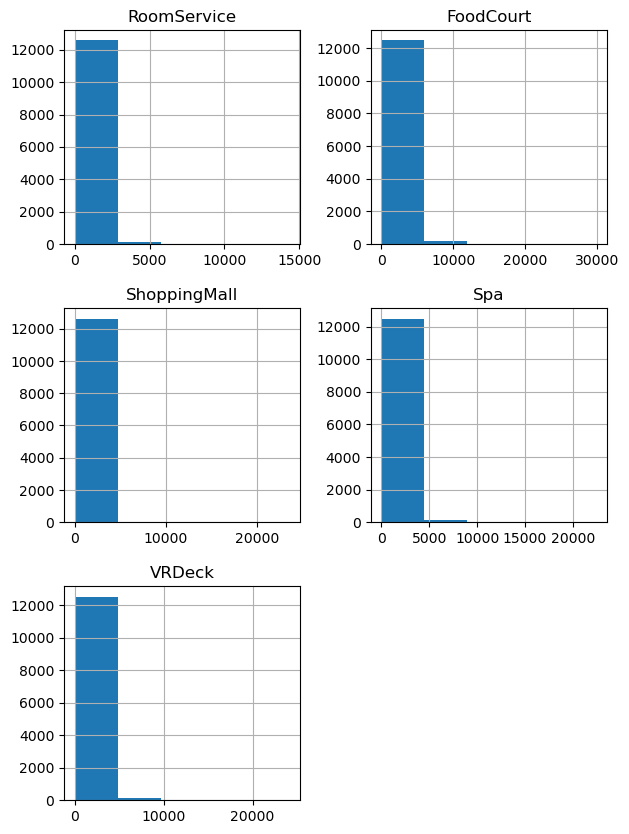

In [64]:
processed_df[payment_col_list].hist(figsize=(7, 10), bins=5)

대부분 0이고 값을 갖는 행이 500개 미만  
값을 갖는 행에 주목해서 특징 찾아보기
- `VIP` 고객이면 값을 가질 확률이 높다 ?
- `CryoSleep`을 한 고객이면 값을 가질 확률이 낮다 ?

In [65]:
processed_df.groupby('VIP')[payment_col_list].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,
0.0,217.200113,423.104640,172.786820,294.950632,287.530154
1.0,486.349442,1793.651685,273.680451,932.847584,1207.199248


In [66]:
processed_df.groupby('CryoSleep')[payment_col_list].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
0.0,348.90205,703.766139,272.385594,478.382106,476.741349
1.0,1.65951,8.851578,2.258425,9.201132,8.470499


`VIP`와 `CryoSleep`의 여부에 따라 평균값이 크게 차이남  
네가지 그룹으로 나누기

> Q. 상관관계계수는 의미있는 값으로 나타나지 않는데 실제로 평균값의 차이가 크게 나는 이유 ?

In [67]:
processed_df.groupby(['VIP', 'CryoSleep'])[payment_col_list].mean()

RoomService    FoodCourt  ShoppingMall          Spa  \
VIP CryoSleep                                                        
0.0 0.0         342.908350   664.717217    271.370927   461.199465   
    1.0           1.668922     7.966937      2.272347     9.094393   
1.0 0.0         545.095833  1985.845188    305.878151  1038.136929   
    1.0           0.172414   153.142857      0.000000    26.607143   

                    VRDeck  
VIP CryoSleep               
0.0 0.0         450.360499  
    1.0           8.519310  
1.0 0.0        1343.556485  
    1.0           0.185185

In [68]:
filled_payment_col = []

for name, value in processed_df.groupby(['VIP', 'CryoSleep']):
  filled_payment_col.append(value[payment_col_list].fillna(value[payment_col_list].mean()))

filled_payment_col = pd.concat(filled_payment_col).sort_index()
filled_payment_col

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0
12966,0.0,847.0,17.0,10.0,144.0
12967,0.0,0.0,0.0,0.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0


In [69]:
processed_df[payment_col_list] = filled_payment_col
processed_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinSide
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001,B,P
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0002,F,S
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0003,A,S
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0003,A,S
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9266,G,S
12966,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,9269,G,P
12967,Mars,1.0,55 Cancri e,29.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9271,D,P
12968,Europa,0.0,55 Cancri e,34.0,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,9273,D,P


In [70]:
processed_df.isna().sum()

HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Transported       4277
PassengerGroup       0
CabinDeck            0
CabinSide            0
dtype: int64

## 학습데이터, 테스트 데이터

In [71]:
all_data = processed_df.copy()
all_data.drop('PassengerGroup', axis=1, inplace=True)
all_data = pd.get_dummies(all_data, columns=['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'])
all_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,1,...,0,0,0,0,0,1,0,0,0,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,0,0,0,0,0,0,1,0,0,1
12966,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,1,...,0,0,0,0,0,0,1,0,1,0
12967,1.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,...,0,0,0,1,0,0,0,0,1,0
12968,0.0,34.0,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,0,...,0,0,0,1,0,0,0,0,1,0


In [72]:
train_idx = train_df.shape[0]
X_data = all_data.drop('Transported', axis=1)
y_data = all_data['Transported']

In [73]:
scaler = StandardScaler()
scaled_X_data = scaler.fit_transform(X_data)
scaled_X_data = pd.DataFrame(scaled_X_data, columns=X_data.columns)
scaled_X_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,-0.754499,0.718016,-0.146633,-0.347544,-0.288123,-0.298675,-0.275489,-0.262643,-1.094841,1.756428,...,-0.167510,3.102006,-0.304721,-0.242437,-0.337033,-0.703757,-0.660909,-0.029135,0.995231,-0.995231
1,-0.754499,-0.335064,-0.146633,-0.177608,-0.282381,-0.255860,0.215423,-0.224983,0.913374,-0.569337,...,-0.167510,-0.322372,-0.304721,-0.242437,-0.337033,1.420946,-0.660909,-0.029135,-1.004792,1.004792
2,-0.754499,2.051918,6.819762,-0.280505,1.993113,-0.298675,5.729017,-0.220704,-1.094841,1.756428,...,5.969792,-0.322372,-0.304721,-0.242437,-0.337033,-0.703757,-0.660909,-0.029135,-1.004792,1.004792
3,-0.754499,0.296784,-0.146633,-0.347544,0.530341,0.336706,2.701280,-0.097455,-1.094841,1.756428,...,5.969792,-0.322372,-0.304721,-0.242437,-0.337033,-0.703757,-0.660909,-0.029135,-1.004792,1.004792
4,-0.754499,-0.896707,-0.146633,0.124848,-0.243468,-0.040070,0.229730,-0.260931,0.913374,-0.569337,...,-0.167510,-0.322372,-0.304721,-0.242437,-0.337033,1.420946,-0.660909,-0.029135,-1.004792,1.004792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1.325384,0.366989,-0.146633,-0.347544,-0.288123,-0.298675,-0.275489,-0.262643,0.913374,-0.569337,...,-0.167510,-0.322372,-0.304721,-0.242437,-0.337033,-0.703757,1.513068,-0.029135,-1.004792,1.004792
12966,-0.754499,0.928632,-0.146633,-0.347544,0.252204,-0.269561,-0.266547,-0.139394,0.913374,-0.569337,...,-0.167510,-0.322372,-0.304721,-0.242437,-0.337033,-0.703757,1.513068,-0.029135,0.995231,-0.995231
12967,1.325384,0.015963,-0.146633,-0.347544,-0.288123,-0.298675,-0.275489,-0.262643,-1.094841,-0.569337,...,-0.167510,-0.322372,-0.304721,4.124790,-0.337033,-0.703757,-0.660909,-0.029135,0.995231,-0.995231
12968,-0.754499,0.366989,-0.146633,-0.347544,1.421528,-0.298675,-0.275489,0.184991,-1.094841,1.756428,...,-0.167510,-0.322372,-0.304721,4.124790,-0.337033,-0.703757,-0.660909,-0.029135,0.995231,-0.995231


In [74]:
train_X = scaled_X_data[:train_idx]
train_y = y_data[:train_idx]

test_X = scaled_X_data[train_idx:].reset_index(drop=True)

In [75]:
# rf = RandomForestClassifier()
# rf.fit(train_X, train_y)
# test_y = rf.predict(test_X)

lr = LogisticRegression()
lr.fit(train_X, train_y)
test_y = lr.predict(test_X) 
test_y

array([1., 0., 1., ..., 1., 1., 1.])

In [76]:
submission_df = pd.read_csv('spaceship-titanic/sample_submission.csv')
submission_df['Transported'] = test_y.astype(bool)
submission_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [77]:
submission_df.to_csv('submission_logistic.csv', index=False)